## 03- Entrenamiento del Modelo

En este notebook realizaremos los procedimientos necesarios para entrenar el modelo que permita establecer la probabilidad de que un cliente no renueve su producto con la compañía, basado en las diferentes dimensiones de información que se tengan del mismo al momento de emitir la póliza y que hemos explorado en los notebooks anteriores. Para ello usaremos las ventajas de la librería `scikit-learn`.

In [42]:
from model_parameters import *
import pandas as pd
import numpy as np
from utils import metrics,get_confusion_plot

data=pd.read_csv("data_modelacion.csv",sep=";",dtype={'Asegurado__c':str,'NumeroPoliza__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str}).drop(columns=['NumeroPoliza__c'])

## Generar Particiones de Datos

Se debe generar una partición de la data para test(10%), el restante se usará para entrenamiento y validación.

In [43]:
#Definir esquema para valores faltantes
num_cols=[i for i in data.columns.values.tolist() if data[i].dtype!="O" and i not in ['churn','Profesion__pc','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','Tipo_poliza_c']]
str_cols=[i for i in data.columns.values.tolist() if data[i].dtype not in ["int32","float","int64"] and i not in ['churn','NumeroPoliza__c','Producto__c','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','Tipo_poliza_c']]
train,test=train_test_split(data, test_size=0.10,random_state=123)

## Modelos a Evaluar

Se procede a evaluar dos tipos de modelos de tipo boosting (XGboost,LightGBM), los cuales son ampliamente usados en el modelamiento predictivo. A su vez, se prueba un modelo sencillo como la regresión logística, para comparar el desempeño frente a modelos de mayor complejidad. El objetivo general de esta comparación es establecer qué tipo de modelo puede encontrar los aspectos más relevantes para establecer cuándo un cliente tiene mayor propensión a renovar su producto con la compañía.

In [44]:
from sklearn import set_config
set_config(display='diagram')

In [4]:
X_train,Y_train=train.drop(columns=["churn","Asegurado__c"]),train['churn'].values

In [53]:
## Pasos de imputación y estandarización

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import FunctionTransformer

##función custom para pasar de string a categoría
def to_category(x):
  return pd.DataFrame(x).astype("category")

#CategoryTransformer = FunctionTransformer(to_category)


def get_classifier_model(model_name:str,k_cv:int=5,scoring="f1",imputer="zero",scaler_method="standard",one_hot_str=True) -> GridSearchCV:
    """retorna un objeto GridSearchCV para entrenar con @param model_name y k_cv-fold Cross Validation
    para clasificación binaria, la métrica de scoring de los modelos está dada por @param scoring
    @param imputer: str | "zero" usa como enfoque de imputación poner 0 a los valores perdidos, otro valor usa el enfoque de asignar la mediana.
    @param scaler_method: str | "standard" define StandardScaler para escalar variables numéricas, otro valor lo define como MinMaxScaler
    @param enable_str_tf: Boolean | True activa one-hot-encoding para las variables categóricas
    """

    if scaler_method=="standard":
        scl=StandardScaler()
    else:
        scl=MinMaxScaler()

    if imputer=="zero":
        imp=SimpleImputer(strategy="constant",fill_value=0)
    else:
        imp=SimpleImputer(strategy="median")

    num_transformer = Pipeline(
    steps=[("imputer", imp), ("scaler",scl)]
    )

    if one_hot_str:
        cat_transformer = OneHotEncoder(handle_unknown="error")
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    else:
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", SimpleImputer(strategy="constant",fill_value="otros"), str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )

    model=MODEL_LIST[model_name]
    pipe=Pipeline([
        ('cleaner',preprocessor),
        ('pca',PCA()),
        ('model',model)

    ], verbose=True)

    param_grid=MODEL_PARAMS[model_name]['param_grid']

    grid=GridSearchCV(pipe,param_grid,cv=k_cv,refit=True,scoring=scoring,verbose=True,n_jobs=-1)
    return grid

xgb=get_classifier_model("xgboost")
logistic=get_classifier_model("logistic_regression")
lightgbm=get_classifier_model("lightgbm")

In [54]:
xgb.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=  53.5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                          'TipoVehiculo__c',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc'])])),
                                       ('pca', PCA()),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100, 250],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [55]:
logistic.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=  33.5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                         ['tipo_poliza_name',
                                                                          'tipo_prod_desc',
                                                                          'ClaseVehiculo__c',
                                                                          'TipoVehiculo__c',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [56]:
lightgbm.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [5, 10, 20]},
             scoring='f1', verbose=True)

## Verificar desempeño de los modelos

A continuación se proponen métricas generales para evaluar el desempeño de los modelos entrenados para las bases de entrenamiento y test.

In [57]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),xgb.predict(X_train))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),xgb.predict(test.drop(columns=["churn","Asegurado__c"])))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),logistic.predict(X_train))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),logistic.predict(test.drop(columns=["churn","Asegurado__c"])))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),lightgbm.predict(X_train))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),lightgbm.predict(test.drop(columns=["churn","Asegurado__c"])))

===Métricas para XGboost===


	 Training

 Accuracy:0.9084 
 Precision: 0.9297 
 Recall: 0.4654 
 Kappa: 0.5747 
 F1-Score: 0.6203 

	 Test 

 Accuracy:0.8747 
 Precision: 0.7552 
 Recall: 0.3181 
 Kappa: 0.3899 
 F1-Score: 0.4476 

===Métricas para Regresión Logística===


	 Training

 Accuracy:0.8184 
 Precision: 0.4556 
 Recall: 0.6617 
 Kappa: 0.4313 
 F1-Score: 0.5396 

	 Test 

 Accuracy:0.8194 
 Precision: 0.4557 
 Recall: 0.6751 
 Kappa: 0.4368 
 F1-Score: 0.5441 

===Métricas para LightGBM===


	 Training

 Accuracy:0.9046 
 Precision: 0.8990 
 Recall: 0.4582 
 Kappa: 0.5592 
 F1-Score: 0.6070 

	 Test 

 Accuracy:0.8702 
 Precision: 0.6853 
 Recall: 0.3453 
 Kappa: 0.3945 
 F1-Score: 0.4592 


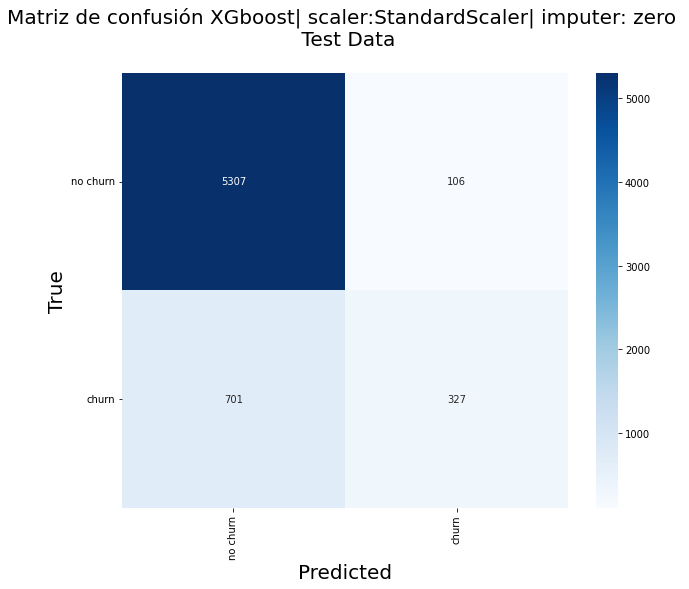

In [71]:
## Matriz de confusión para el mejor modelo
get_confusion_plot(test['churn'].values.ravel(),xgb.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión XGboost| scaler:StandardScaler| imputer: zero \n Test Data\n")

## Otros enfoques de entrenamiento

Debido a la gran variedad de modelos y de técnicas para intentar maximizar el desempeño de los mismos, es necesario explorarlas. Dependiendo del enfoque, tiempo disponible u otros factores, se pueden abordar más modelos o modificaciones de los modelos evaluados y comparar los resultados. A continuación intentamos evaluar el desempeño, usando otras técnicas de imputación de datos y enfoque para el escalado de variables numéricas.


In [59]:
xgb_2=get_classifier_model("xgboost",scaler_method="minmax",imputer="median")
logistic_2=get_classifier_model("logistic_regression",scaler_method="minmax",imputer="median")
lightgbm_2=get_classifier_model("lightgbm",scaler_method="minmax",imputer="median")

In [60]:
xgb_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing model, total= 1.3min


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                          'TipoVehiculo__c',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc'])])),
                                       ('pca', PCA()),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100, 250],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [61]:
logistic_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                         ['tipo_poliza_name',
                                                                          'tipo_prod_desc',
                                                                          'ClaseVehiculo__c',
                                                                          'TipoVehiculo__c',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [62]:
lightgbm_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [5, 10, 20]},
             scoring='f1', verbose=True)

In [63]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),xgb_2.predict(X_train))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),xgb_2.predict(test.drop(columns=["churn","Asegurado__c"])))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),logistic_2.predict(X_train))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),logistic_2.predict(test.drop(columns=["churn","Asegurado__c"])))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
_=metrics(Y_train.ravel(),lightgbm_2.predict(X_train))
print("\n\t Test \n")
_=metrics(test['churn'].values.ravel(),lightgbm_2.predict(test.drop(columns=["churn","Asegurado__c"])))

===Métricas para XGboost===


	 Training

 Accuracy:0.9043 
 Precision: 0.9212 
 Recall: 0.4430 
 Kappa: 0.5514 
 F1-Score: 0.5983 

	 Test 

 Accuracy:0.8634 
 Precision: 0.6504 
 Recall: 0.3113 
 Kappa: 0.3543 
 F1-Score: 0.4211 

===Métricas para Regresión Logística===


	 Training

 Accuracy:0.7808 
 Precision: 0.3955 
 Recall: 0.6868 
 Kappa: 0.3742 
 F1-Score: 0.5019 

	 Test 

 Accuracy:0.7850 
 Precision: 0.3989 
 Recall: 0.6848 
 Kappa: 0.3788 
 F1-Score: 0.5041 

===Métricas para LightGBM===


	 Training

 Accuracy:0.8813 
 Precision: 0.7533 
 Recall: 0.3894 
 Kappa: 0.4535 
 F1-Score: 0.5134 

	 Test 

 Accuracy:0.8583 
 Precision: 0.6044 
 Recall: 0.3239 
 Kappa: 0.3493 
 F1-Score: 0.4218 


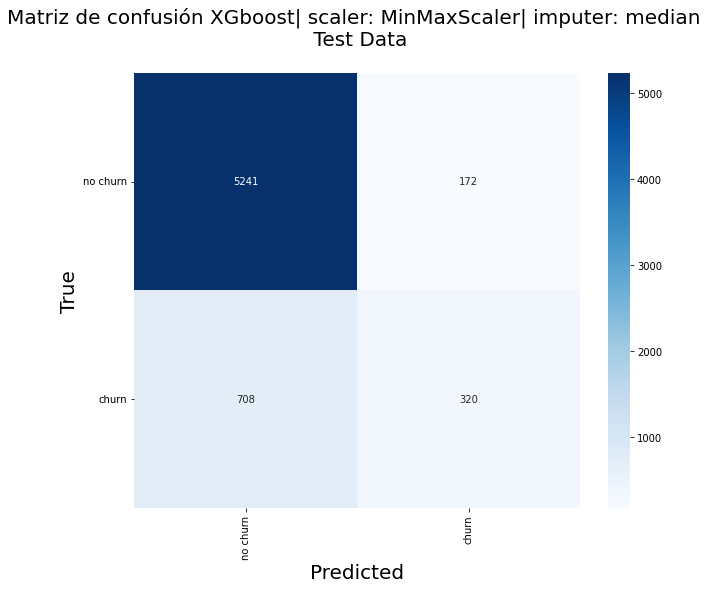

In [72]:
get_confusion_plot(test['churn'].values.ravel(),xgb_2.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión XGboost| scaler: MinMaxScaler| imputer: median \n Test Data\n")

Vemos que el mejor modelo fue la versión inicial de XGBoost, el cual presenta los mejores indicadores de desempeño. Sin embargo, cabe la posibilidad de explorar modelos adicionales o mas hiperparámetros de los modelos propuestos.

### Exportar modelos para futuro uso

In [65]:
import pickle
import os

if not os.path.isdir("models"):
    os.mkdir("models")

with open("models/xgbmodel.pickle","wb") as f:
    pickle.dump(xgb,f)

with open("models/logistic.pickle","wb") as f:
    pickle.dump(logistic,f)

with open("models/lightgbm.pickle","wb") as f:
    pickle.dump(lightgbm,f)

In [20]:
##reutilizar | leer modelos guardados
import pickle
with open("models/logistic.pickle", 'rb') as f:
    logistic = pickle.load(f)